<a href="https://colab.research.google.com/github/pipoomm/topologyzoo/blob/main/mumu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
from networkx.algorithms.shortest_paths.astar import astar_path_length

import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from itertools import chain

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tabulate import tabulate

import copy
import requests
from io import StringIO, BytesIO

In [2]:
def read_graphml_from_url(url):
    # Download the GraphML file
    response = requests.get(url)
    if response.status_code == 200:
        # Parse the GraphML content using NetworkX
        graphml_data = response.text
        graphml_file = StringIO(graphml_data)
        graph = nx.read_graphml(graphml_file)
        return graph
    else:
        raise Exception(f"Error downloading GraphML file. Status code: {response.status_code}")

## Preparing graph

In [3]:
# Load GraphML file
G = read_graphml_from_url("https://raw.githubusercontent.com/pipoomm/topologyzoo/main/AttMpls.graphml")

In [4]:
# Find nodes without 'Latitude' or 'Longitude' attributes
nodes_to_remove = [n for n, d in G.nodes(data=True) if 'Latitude' not in d or 'Longitude' not in d]

# Remove nodes and their connected edges
G.remove_nodes_from(nodes_to_remove)

In [5]:
# Set the initial role of all nodes to "none"
roles = {}
for n in G.nodes():
    roles[n] = "none"

In [6]:
amount_of_controller = 0
amount_of_switch = 0
# Repeatedly identify "controller" and "switch" nodes until all nodes are defined
while "none" in roles.values():
    # Select the node with the highest number of connected neighbors and no role assigned
    candidates = [n for n in G.nodes() if roles[n] == "none"]
    node_degrees = [(n, G.degree(n)) for n in candidates]
    node_degrees.sort(key=lambda x: (-x[1], x[0]))
    node_i = node_degrees[0][0]

    # Assign the "controller" role to node i
    roles[node_i] = "controller"
    amount_of_controller += 1

    # Assign the "switch" role to all 1-hop connected nodes (neighbors) of node i with no role assigned
    for neighbor in G.neighbors(node_i):
        if roles[neighbor] == "none":
            roles[neighbor] = "switch"
            amount_of_switch += 1
            
# Set the role attribute for each node
nx.set_node_attributes(G, roles, "role")
print(f'Amount of controller: {amount_of_controller}\nAmount of switch: {amount_of_switch}')

Amount of controller: 8
Amount of switch: 17


In [ ]:
# Print the node roles
for n, r in nx.get_node_attributes(G, "role").items():
    print(f"Node {n} is a {r}")

In [ ]:
for n, data in G.nodes(data=True):
    print(f"Node {n}: {data}")

In [ ]:
[n for n in G.neighbors('17')]

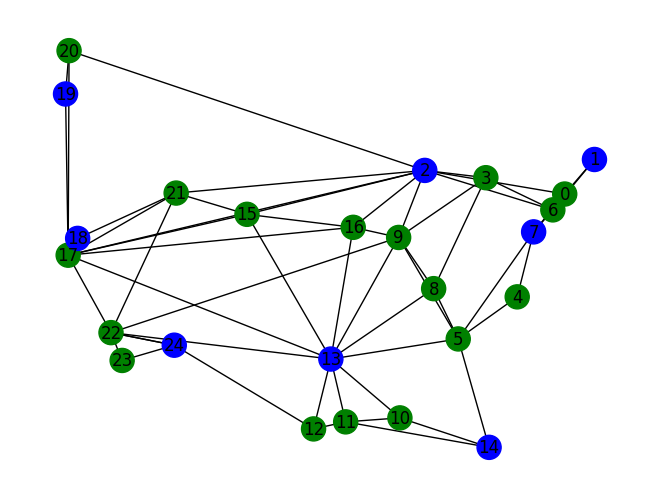

In [7]:
node_positions = {}
for node in G.nodes():
  label = G.nodes[node]['id']
  node_positions[node] = (G.nodes[node]['Longitude'], G.nodes[node]['Latitude'])

# Define node colors based on their roles
node_colors = {"controller": "blue", "switch": "green"}

# Draw the graph with node colors
nx.draw(G, node_color=[node_colors[G.nodes[n]["role"]] for n in G.nodes()], pos=node_positions, labels={node: G.nodes[node]['id'] for node in G.nodes()},with_labels=True)

# Show the plot
plt.show()

### Stage 1 - Matching switch wth nearest controller

In [9]:
# Step 4: Set `selected_con` attribute for switch nodes
def setSelectedCon():
  candidate_controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]
  global switch_to_controller_list
  switch_to_controller_list = [] 
  for node_id in G.nodes():
    if G.nodes[node_id]['role'] == 'switch':
      hop_counts = []
      for con in candidate_controllers:
        path = nx.astar_path(G, source=node_id, target=con)
        hop_count = len(path) - 1
        hop_counts.append([con, hop_count, 0])
      sorted_hops = sorted(hop_counts, key=lambda x: (x[1]), reverse=False)
      G.nodes[node_id]['selected_con'] = sorted_hops[0][0]
      switch_to_controller_list.append([node_id,0]+sorted_hops)

In [ ]:
switch_to_controller_list

In [10]:
def printSwitchController():
    # Find controlled switches for each controller node
    controllers = {node_id: [] for node_id in G.nodes() if G.nodes[node_id]['role'] == 'controller'}
    switches = {node_id: G.nodes[node_id]["selected_con"] for node_id in G.nodes() if G.nodes[node_id]['role'] == 'switch'}
    controlled_switches = {controller: [switch for switch, selected_con in switches.items() if selected_con == controller] for controller in controllers}

    # Print the list of controlled switches for each controller node
    # Create a list to store the table rows
    table_rows = []

    # Iterate over the controlled switches for each controller node
    for controller_id, switches in controlled_switches.items():
        # Combine the switch IDs into a single string separated by commas
        switch_list = ', '.join(switch_id for switch_id in switches)
        
        # Add a row to the table with the controller ID and the combined switch list
        table_rows.append([controller_id, switch_list])

    # Define the table headers
    headers = ["Controller node", "Switch nodes"]

    # Print the table using tabulate
    print(tabulate(table_rows, headers=headers))

In [ ]:
printSwitchController()

In [11]:
def findHopcount(switch_source, controller_dest):
    matching_switch = next((item for item in switch_to_controller_list if item[0] == switch_source), None)

    if matching_switch:
        hop_count = next((j[1] for j in matching_switch[2:] if j[0] == controller_dest), None)
        return hop_count

    return None

In [36]:
def find_value_differences(input_list):
    differences = sorted({
        abs(input_list[i] - input_list[j])
        for i in range(len(input_list))
        for j in range(i+1, len(input_list))
    })

    return 1 if differences[0] == 0 else differences[0]

In [ ]:
setSelectedCon()

# Update controller and switch (Stage 2 - Load balancing for overload controller)



In [12]:
def findSwitchtoMigrateList():
  #List of ovelload controlller and swich that need to do migation list
  switches_to_migrate = {}
  overloaded_controllers = [node for node in G.nodes() if G.nodes[node]['role'] == 'controller' and controller_loads[node] > capacity]
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch' and G.nodes[node]['selected_con'] in overloaded_controllers:
      overloaded_controller = G.nodes[node]['selected_con']
      if overloaded_controller not in switches_to_migrate:
        switches_to_migrate[overloaded_controller] = []
      switches_to_migrate[overloaded_controller].append([node,packet_amount[node]])
      # switches_to_migrate[node] = packet_amount[node]
  
  # Sort the keys of switches_to_migrate based on the values in controller_loads
  sorted_keys = sorted(switches_to_migrate.keys(), key=lambda x: controller_loads[x], reverse=True)

  # Reconstruct the switches_to_migrate dictionary using the sorted keys
  sorted_switches_to_migrate = {key: switches_to_migrate[key] for key in sorted_keys}
  
  return(sorted_switches_to_migrate)
# {'Overload ControllerID : [['SwitchID','Switch load'], ['SwitchID','Switch load'] ]'}

In [13]:
def findCandidateControllerList(switches_to_migrate):
    # Find new candidate controllers for overloaded controllers
    switch_to_candidate_controller = []
    
    for overload_controller, switches in switches_to_migrate.items():
        candidate_controllers = []
        
        for switch, load in switches:
            selected_con = overload_controller
            conlist = next((item for item in switch_to_controller_list if item[0] == switch), None)
            
            if conlist:
                hop_count = [
                    [con[0], con[1], capacity - controller_loads[con[0]]] for con in conlist[2:]
                    if con[0] != selected_con and controller_loads[con[0]] < capacity
                ]
                
                sorted_hop_count = sorted(hop_count, key=lambda x: (x[1], -x[2]))
                switch_to_candidate_controller.append([switch, load] + sorted_hop_count)
    
    return switch_to_candidate_controller
# ['SwitchID', 'Switch load', ['Dest.ControllerID', 'Hop count from switch to controller', 'Controller capacity left']]

In [ ]:
switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)
# Show candidate controller list of switch that connected with overload controller
for i in switch_to_candidate_controller:
    print(f"Switch {i[0]} ({i[1]} pps) can migrate to the following controllers:")
    
    # Create a list of dictionaries for tabulate
    data = [
        {"Controller": con[0], "Hop count": con[1], "Capacity left": con[2]} for con in i[2:]
    ]
    
    # Print the table
    print(tabulate(data, headers="keys"))
    print()

## Min-Knapsack

### By sorting lowest delta_E

In [ ]:
def min_knapsack2_mod(switches_to_migrate, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (0.9 * capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack2` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        # Calculate delta_E for each candidate controller
        delta_Es = [[switch, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
        if delta_Es:
          min_element = min(delta_Es, key=lambda x: x[2])
          result = [min_element]
          x1.append(result)
      x1 = sorted(x1, key=lambda x: min(sublist[2] for sublist in x))
      print(f'from con{overloaded_controllers}: {x1}')

      x2 = []
      controller_load_update = {}
      total_loads = 0
      for sublist in x1:
        passed_condition = True
        new_total_loads = total_loads
        for switch, con, delta_E in sublist:
          passed_condition = True
          new_total_loads = total_loads
          for switch, con, delta_E in sublist:
            if switch in switches and new_total_loads < target_loads[overloaded_controllers]:
                new_total_loads += switches[switch]
                load = switches[switch]
                if con in controller_load_update:
                    controller_load_update[con] += load
                else:
                    controller_load_update[con] = load
            else:
                passed_condition = False
                break
          
          if passed_condition:
              x2.append(sublist)
              total_loads = new_total_loads

      # Update controller load before going next overload controller 
      controller_loads[overloaded_controllers] -= total_loads
      for key in controller_load_update:
        controller_loads[key] += controller_load_update[key]

      if overloaded_controllers in delta_E_per_controller:
          delta_E_per_controller[overloaded_controllers].append(x2)
      else:
          delta_E_per_controller[overloaded_controllers] = x2
    
    return delta_E_per_controller

In [ ]:
result = min_knapsack2_mod(switches_to_migrate, capacity)
result

target_loads: {'13': 1111.0, '2': 1042.0, '7': 1013.0, '18': 338.0, '1': 255.0, '14': 181.0}
from con13: [[['12', '24', 0]], [['22', '24', 0]], [['8', '24', 772]]]
from con2: [[['15', '19', 376]], [['16', '19', 432]], [['9', '19', 710]]]
from con7: []
from con18: []
from con1: []
from con14: []


{'13': [[['12', '24', 0]], [['22', '24', 0]], [['8', '24', 772]]],
 '2': [[['15', '19', 376]], [['16', '19', 432]], [['9', '19', 710]]],
 '7': [],
 '18': [],
 '1': [],
 '14': []}

### By using min-knapsack soving algorithm (**dynamic programming** approach)

#### sim

In [14]:
# Define the packet handling capacity for controllers (1500 packets/second)
capacity = 1500

# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
controller_loads = {c: 0 for c in controllers}

packet_amount = {}

seed = 650631030  # seed value for reproducibility
packet_rate = 505    # average rate or expected value
size = amount_of_switch  # number of switch
packet_size = {}

for t in range(10):
  # Creating a random number generator with a fixed seed
  rng = np.random.default_rng(seed)
  seed *= seed
  
  # Generating values from a Poisson distribution using the seeded generator
  packet_size[t] = rng.poisson(lam=packet_rate, size=size)
  print(f"Generated Poisson samples with fixed seed t={t+1}: {packet_size[t]}")
  packetsum = sum(packet_size[t])
  print(f'Sum of packet size: {packetsum}')

Generated Poisson samples with fixed seed t=1: [501 477 520 487 535 557 490 467 488 492 546 512 492 488 586 517 473]
Sum of packet size: 8628
Generated Poisson samples with fixed seed t=2: [522 518 522 496 511 499 509 476 544 483 574 495 512 533 485 550 523]
Sum of packet size: 8752
Generated Poisson samples with fixed seed t=3: [466 499 537 478 481 489 502 534 511 516 508 530 497 493 514 511 514]
Sum of packet size: 8580
Generated Poisson samples with fixed seed t=4: [470 520 522 553 516 493 551 542 523 526 502 527 483 456 501 538 483]
Sum of packet size: 8706
Generated Poisson samples with fixed seed t=5: [496 518 475 494 543 488 474 513 495 498 508 500 439 526 473 489 503]
Sum of packet size: 8432
Generated Poisson samples with fixed seed t=6: [482 514 511 503 498 548 469 471 498 531 539 462 475 525 517 513 510]
Sum of packet size: 8566
Generated Poisson samples with fixed seed t=7: [495 483 475 480 474 528 522 490 482 528 470 524 523 542 472 534 544]
Sum of packet size: 8566
Genera

In [15]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
sim_time = 1
setSelectedCon()
for i in range(sim_time):
    # Generate packets for each switch and send to its selected controller
    k = 0
    for node in G.nodes():
        if G.nodes[node]['role'] == 'switch':
            selected_con = G.nodes[node]['selected_con']
            packet_count = packet_size[i][k]
            k += 1
            packet_amount[node] = packet_count
            controller_loads[selected_con] += packet_count
            print(f"Switch {node} generated {packet_count} packets and sent to controller {selected_con}")

    # Update controller load every second
    if i % 1 == 0:
        print()
        print("Controller loads after", i+1, "seconds:")
        print(f"Controller capacity: {capacity}",end='\n\n')
        for node in G.nodes():
            if G.nodes[node]['role'] == 'controller':
                print(f"Controller {node} load: {controller_loads[node]} pps")
                if controller_loads[node] > capacity:
                  print(f"Controller {node} is overloaded!")
        print()

Switch 0 generated 501 packets and sent to controller 1
Switch 3 generated 477 packets and sent to controller 2
Switch 4 generated 520 packets and sent to controller 7
Switch 5 generated 487 packets and sent to controller 7
Switch 6 generated 535 packets and sent to controller 1
Switch 8 generated 557 packets and sent to controller 13
Switch 9 generated 490 packets and sent to controller 2
Switch 10 generated 467 packets and sent to controller 13
Switch 11 generated 488 packets and sent to controller 13
Switch 12 generated 492 packets and sent to controller 13
Switch 15 generated 546 packets and sent to controller 2
Switch 16 generated 512 packets and sent to controller 2
Switch 17 generated 492 packets and sent to controller 2
Switch 20 generated 488 packets and sent to controller 2
Switch 21 generated 586 packets and sent to controller 2
Switch 22 generated 517 packets and sent to controller 13
Switch 23 generated 473 packets and sent to controller 24

Controller loads after 1 second

In [16]:
switches_to_migrate = findSwitchtoMigrateList()
switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

#### code

In [26]:
def expandDP(dp, items, new_max_weight):
    n = len(items)
    max_weight = len(dp[0])

    if new_max_weight <= max_weight - 1:
        return dp

    for row in dp:
        row.extend([float('inf')] * (new_max_weight - max_weight + 1))
  
    for i in range(1, n+1):
        weight, value = items[i - 1][1], items[i - 1][3]
        for j in range(max_weight, new_max_weight + 1):
            if weight <= j:
                dp[i][j] = min(dp[i - 1][j], dp[i - 1][j - weight] + value)
            else:
                dp[i][j] = dp[i - 1][j]

    return dp

In [1]:
def min_knapsack_GPT(target_weight, items):
    # Get the number of items
    n = len(items)
    
    # Calculate the maximum possible weight and initialize the dynamic programming table
    init_max_weight = target_weight + 1

    differences_weight = find_value_differences([item[1] for item in items])
    
    sum_total_weight = sum(item[1] for item in items)
    dp = [[float('inf')] * init_max_weight for _ in range(n + 1)]

    # Initialize the first column of the table with 0
    for i in range(n + 1):
        dp[i][0] = 0

    # Iterate through the items and fill in the dynamic programming table
    for i in range(1, n + 1):
        weight, value = items[i - 1][1], items[i - 1][3]
        for j in range(init_max_weight):
            if weight <= j:
                # If the item can be included, find the minimum value with or without the item
                dp[i][j] = min(dp[i - 1][j], dp[i - 1][j - weight] + value)
            else:
                # If the item cannot be included, the value remains the same as the previous row
                dp[i][j] = dp[i - 1][j]

    # Find the minimum value for the target weight or greater
    min_value = float('inf')
    min_weight = -1

    weight = target_weight # Start knapsack weight -> to find minimum value 
    new_max_weight = init_max_weight

    while weight < len(dp[n]) and weight < sum_total_weight:
        value = dp[n][weight]
        if value < min_value:
            min_value = value
            min_weight = weight
            break
        else:
            new_max_weight += differences_weight
            expanded_dp = expandDP(dp, items, new_max_weight)
            
        weight += 1

    # If there is no solution, return -1 and an empty list
    if min_value == float('inf'):
        return -1, []

    # Backtrack through the dynamic programming table to find the selected items
    selected_items = []
    i, j = n, min_weight
    while i > 0 and j > 0:
        if dp[i][j] != dp[i - 1][j]:
            selected_items.append([items[i - 1][0],items[i - 1][2],items[i - 1][3]])
            j -= items[i - 1][1]
        i -= 1

    # Return the minimum value and the selected items
    return min_value, selected_items, min_weight

In [46]:
def min_knapsack3_dp(switches_to_migrate, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (1 * capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack2` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      controller_candidates = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)
      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        for item in switch_to_candidate_controller:
          if item[0] == switch and overloaded_controllers == G.nodes[switch]['selected_con']:
              filtered_candidates = []
              for candidate in item[2:]:
                if candidate[2] >= load:
                    filtered_candidates.append(candidate)
                controller_candidates = filtered_candidates
              break

        # Calculate delta_E for each candidate controller
        delta_Es = [[switch, load, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
        # Select pairs of switch and controller with highest capacity controller left and lowest delta_E of each switch to filtered out of duplicate switch
        
        if delta_Es:
          min_element = min(delta_Es, key=lambda x: x[3])
          result = min_element
          x1.append(result)
      print(f'x1: {x1}')
      result_x1, x1, total_loads = min_knapsack_GPT(target_loads[overloaded_controllers], x1)
      print(f'\n Selected it: {x1}')
      print(f"Minimum value (sum delta_E): {result_x1}")
      print(f"Weight (sum switches load): {total_loads}")

      # controller_load_update = {}
      # for switch, con, delta_E in x1:
      #   load = switches[switch]
      #   if con in controller_load_update:
      #       controller_load_update[con] += load
      #   else:
      #       controller_load_update[con] = load
      # Update controller load before going next overload controller 
      # controller_loads[overloaded_controllers] -= total_loads
      # for key in controller_load_update:
      #   controller_loads[key] += controller_load_update[key]

      if overloaded_controllers in delta_E_per_controller:
          delta_E_per_controller[overloaded_controllers].append(x1)
      else:
          delta_E_per_controller[overloaded_controllers] = x1

    return delta_E_per_controller

In [47]:
result2 = min_knapsack3_dp(switches_to_migrate, capacity)
print(result2)

target_loads: {'2': 2091, '13': 1021}
x1: [['3', 477, '7', 477], ['9', 490, '14', 490], ['15', 546, '18', 546], ['16', 512, '18', 512], ['17', 492, '18', 0], ['20', 488, '19', 0], ['21', 586, '18', 0]]

 Selected it: [['21', '18', 0], ['20', '19', 0], ['15', '18', 546], ['3', '7', 477]]
Minimum value (sum delta_E): 1023
Weight (sum switches load): 2097
x1: [['8', 557, '14', 557], ['10', 467, '14', 0], ['11', 488, '14', 0], ['12', 492, '24', 0], ['22', 517, '24', 0]]

 Selected it: [['10', '14', 0], ['8', '14', 557]]
Minimum value (sum delta_E): 557
Weight (sum switches load): 1024
{'2': [['21', '18', 0], ['20', '19', 0], ['15', '18', 546], ['3', '7', 477]], '13': [['10', '14', 0], ['8', '14', 557]]}


### By using min-knapsack soving algorithm (**greedy** approach)

In [ ]:
def min_knapsack_GPT2(target_weight, items):
    n = len(items)
    ratios = [(items[i][3]/items[i][1], items[i][1], items[i][3], i) for i in range(n)]
    ratios.sort()
    total_weight = 0
    total_value = 0
    knapsack = []
    for i in range(n):
        if total_weight + ratios[i][1] <= target_weight:
            total_weight += ratios[i][1]
            total_value += ratios[i][2]
            knapsack.append(ratios[i][3])
        else:
            break
    while total_weight < target_weight:
        total_weight += ratios[i][1]
        total_value += ratios[i][2]
        knapsack.append(ratios[i][3])
    knapsack_items = [[items[i][0], items[i][2], items[i][3]] for i in knapsack]

    return total_value, total_weight, knapsack_items

In [ ]:
def min_knapsack3_gd(switches_to_migrate, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (0.9 * capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack2` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        # Calculate delta_E for each candidate controller
        delta_Es = [[switch, load, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
        # Select pairs of switch and controller with highest capacity controller left and lowest delta_E of each switch to filtered out of duplicate switch
        if delta_Es:
          min_element = min(delta_Es, key=lambda x: x[3])
          result = min_element
          x1.append(result)
      result_x1, load, x1 = min_knapsack_GPT2(target_loads[overloaded_controllers], x1)

      print("Minimum cost:", result_x1)
      print("Total weight of the knapsack:", load)
      print("Selected items:", x1)

      # controller_load_update = {}
      # for switch, con, delta_E in x1:
      #   load = switches[switch]
      #   if con in controller_load_update:
      #       controller_load_update[con] += load
      #   else:
      #       controller_load_update[con] = load
      # Update controller load before going next overload controller 
      # controller_loads[overloaded_controllers] -= total_loads
      # for key in controller_load_update:
      #   controller_loads[key] += controller_load_update[key]

      if overloaded_controllers in delta_E_per_controller:
          delta_E_per_controller[overloaded_controllers].append(x1)
      else:
          delta_E_per_controller[overloaded_controllers] = x1

    
    return delta_E_per_controller

In [ ]:
result3 = min_knapsack3_gd(switches_to_migrate, capacity)
result3

target_loads: {'2': 1499.0, '13': 646.0}
Minimum cost: 375
Total weight of the knapsack: 1620
Selected items: [['20', '19', 0], ['17', '18', 0], ['21', '18', 0], ['3', '7', 375]]
Minimum cost: 0
Total weight of the knapsack: 751
Selected items: [['10', '14', 0], ['11', '14', 0]]


{'2': [['20', '19', 0], ['17', '18', 0], ['21', '18', 0], ['3', '7', 375]],
 '13': [['10', '14', 0], ['11', '14', 0]]}

## Print result

In [20]:
def removeInnerlist(result):
  for key in result:
    result[key] = [item[0] for item in result[key]]
  return result
# result = removeInnerlist(result)

In [ ]:
result = removeInnerlist(result)

In [ ]:
result

{'2': [['17', '18', 0], ['20', '19', 0], ['21', '18', 0], ['3', '7', 375]],
 '13': [['10', '14', 0], ['11', '14', 0]]}

In [21]:
def printResult(result):
  for controller, switches in result.items():
    print(f"From controller {controller}")
    table_data = []
    for switch in switches:
        table_data.append([switch[0], switch[1], switch[2]])
    print(tabulate(table_data, headers=["Switch", "To Controller", "Delta_E"]))
    print()

In [ ]:
# Print result from `min_knapsack2_mod`
printResult(result)

In [ ]:
# Print result from `min_knapsack3_dp`
printResult(result2)

## Migrate

In [22]:
def doMigrate(result):
  for switches in result.items():
    for switch in switches[1:]:
      for i in switch:
        node_id = i[0]
        G.nodes[node_id]['selected_con'] = i[1]

In [ ]:
doMigrate(result)

In [ ]:
printSwitchController()

# Evaluate energy cost

In [23]:
def energycostCalculate(G):
  hop_counts = {}
  energycost_oneswitch = {}
  total_energyconsume = 0

  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']
      hopcount = findHopcount(switch_source = node, controller_dest = selected_con)
      # print(f'From sw:{node} load: {packet_amount[node]} to con:{selected_con} hc: {hopcount}')
      energycost_oneswitch[node] = packet_amount[node]  * hopcount

  #Calculate energy cost from all switches by its load and hop counts to its controller
  for switch, ec_oneswitch in energycost_oneswitch.items():
      total_energyconsume += ec_oneswitch
  
  return total_energyconsume

# Simulation

In [117]:
# Define the packet handling capacity for controllers (1500 packets/second)
capacity = 1500

# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
controller_loads = {c: 0 for c in controllers}

In [118]:
seed = 650631030  # seed value for reproducibility
size = amount_of_switch  # number of switch
packet_size = {}
packet_rate = 505  # average rate or expected value
for t in range(10):
  # Creating a random number generator with a fixed seed
  rng = np.random.default_rng(seed)
  seed *= seed
  
  # Generating values from a Poisson distribution using the seeded generator
  packet_size[t] = rng.poisson(lam=packet_rate, size=size)
  print(f"Generated Poisson samples with fixed seed t={t+1}: {packet_size[t]}", end="\t")
  packetsum = sum(packet_size[t])
  print(f'Sum of packet size: {packetsum}')

Generated Poisson samples with fixed seed t=1: [501 477 520 487 535 557 490 467 488 492 546 512 492 488 586 517 473]	Sum of packet size: 8628
Generated Poisson samples with fixed seed t=2: [522 518 522 496 511 499 509 476 544 483 574 495 512 533 485 550 523]	Sum of packet size: 8752
Generated Poisson samples with fixed seed t=3: [466 499 537 478 481 489 502 534 511 516 508 530 497 493 514 511 514]	Sum of packet size: 8580
Generated Poisson samples with fixed seed t=4: [470 520 522 553 516 493 551 542 523 526 502 527 483 456 501 538 483]	Sum of packet size: 8706
Generated Poisson samples with fixed seed t=5: [496 518 475 494 543 488 474 513 495 498 508 500 439 526 473 489 503]	Sum of packet size: 8432
Generated Poisson samples with fixed seed t=6: [482 514 511 503 498 548 469 471 498 531 539 462 475 525 517 513 510]	Sum of packet size: 8566
Generated Poisson samples with fixed seed t=7: [495 483 475 480 474 528 522 490 482 528 470 524 523 542 472 534 544]	Sum of packet size: 8566
Genera

In [ ]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
setSelectedCon()
sim_time = 10
avg_en = 0
for i in range(sim_time):
    # Generate packets for each switch and send to its selected controller
    k = 0
    packet_amount = {}
    for node in G.nodes():
        if G.nodes[node]['role'] == 'switch':
            selected_con = G.nodes[node]['selected_con']
            packet_count = packet_size[i][k]
            k += 1
            packet_amount[node] = packet_count
            controller_loads[selected_con] += packet_count
            # print(f"Switch {node} generated {packet_count} packets and sent to controller {selected_con}")

    # Update controller load every second
    if i % 1 == 0:
        print()
        print("Controller loads after", i+1, "seconds:")
        print(f"Controller capacity: {capacity}",end='\n\n')
        for node in G.nodes():
            if G.nodes[node]['role'] == 'controller':
                print(f"Controller {node} load: {controller_loads[node]} pps")
                if controller_loads[node] > capacity:
                  print(f"Controller {node} is overloaded!")
        print()
        
        # Added code part for migration process
        try:
            printSwitchController()
            switches_to_migrate = findSwitchtoMigrateList()
            result2 = min_knapsack3_dp(switches_to_migrate, capacity)
            print()
            printResult(result2)
            doMigrate(result2)
            print()
            printSwitchController()
        except:
            print("\n Controller capacity left not sufficient!!")
            printSwitchController()

        controller_loads = {c: 0 for c in controllers}
        avg_en += energycostCalculate(G)

        
        # End of added code part
print(f'Avg energy consumption: {avg_en/sim_time}')